# Case study - Predicting the demand for rental bicycles

Data description

    season: The current season (1:winter, 2:spring, 3:summer, 4:fall)
    datetime: The timestamp of data entries
    holiday: weather day is holiday or not
    workingday: if day is neither weekend nor holiday is 1, otherwise is 0
    weather: The Weather forecast for the day
        1: Clear, Few clouds, Partly cloudy, Partly cloudy
        2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    temp: Normalized temperature in Celsius.
    atemp: Normalized feeling temperature in Celsius.
    humidity: Normalized humidity. The values are divided to 100 (max)
    windspeed: Normalized wind speed. The values are divided to 67 (max)
    casual: count of casual users
    registered: count of registered users
    count: count of total rental bikes including both casual and registered



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_log_error, mean_absolute_error


#setting plot parameters

plt.rc('axes',labelsize=16)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', titlesize=16)
plt.rc('legend', fontsize=14)
sns.set_style('whitegrid')


/opt/homebrew/Caskroom/miniforge/base/envs/tf_gpu/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Reading train and test data

df_train = pd.read_csv('bike-sharing-demand/train.csv')
df_test = pd.read_csv('bike-sharing-demand/test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


# Initial observations

The train and test data do not have null values and all columns are of numeric data type except 'datetime' column.

Datetime column is an object type and needs to be converted to datetime format


In [5]:
# converting datetime column to pandas datetime object for plotting


df_train['datetime'] = df_train['datetime'].apply(lambda time:pd.to_datetime(time))

df_train['hour'] = df_train['datetime'].apply(lambda hr: hr.hour)
df_train['day'] = df_train['datetime'].apply(lambda dy:dy.dayofweek)
df_train['month'] = df_train['datetime'].apply(lambda mnth: mnth.month)

df_train.drop('datetime',axis=1, inplace=True)

In [6]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1


In [7]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# Independent features: 
'datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed'

# Dependent variables: 
'casual', 'registered', 'count'

# Looks like the variables 'casual' + 'registered'  = 'count'
so 'casual' and 'registered' variables will be trained and predicted separately and then added to obtain total 'count'

# Categorical independent data: 
'Season', 'holiday', 'workingday', 'weather'

# Numerical independent data: 
'datetime', 'temp', 'atemp', 'humidity', 'windspeed'


In [8]:
# dropping duplicate entries from training data

df_train.drop_duplicates(inplace=True)

# Visualizing the data

<AxesSubplot:xlabel='weather', ylabel='count'>

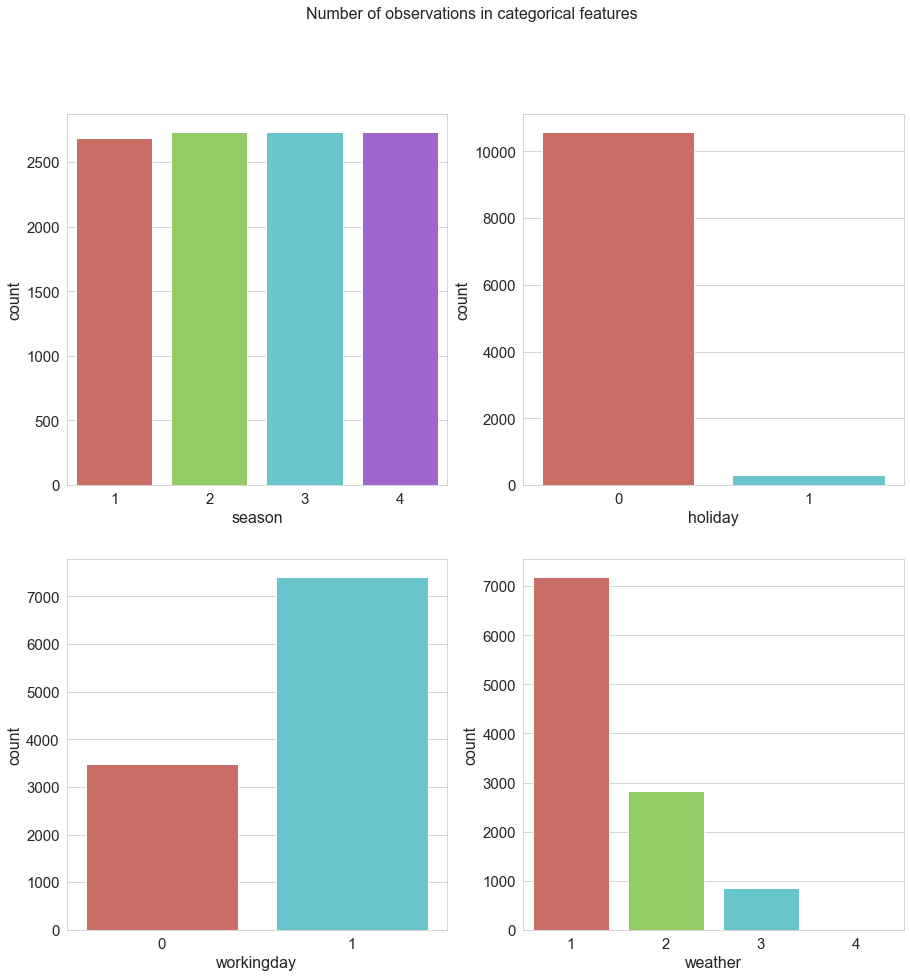

In [9]:
# observing the data distibution of categorical data

fig, ax = plt.subplots(2,2,figsize=(15,15))
plt.suptitle('Number of observations in categorical features', fontsize=16)

sns.countplot(x ='season', data = df_train, ax=ax[0,0], palette='hls')
sns.countplot(x ='holiday', data = df_train, ax=ax[0,1], palette='hls')
sns.countplot(x ='workingday', data = df_train, ax=ax[1,0], palette='hls')
sns.countplot(x ='weather', data = df_train, ax=ax[1,1], palette='hls')


<AxesSubplot:xlabel='atemp', ylabel='Count'>

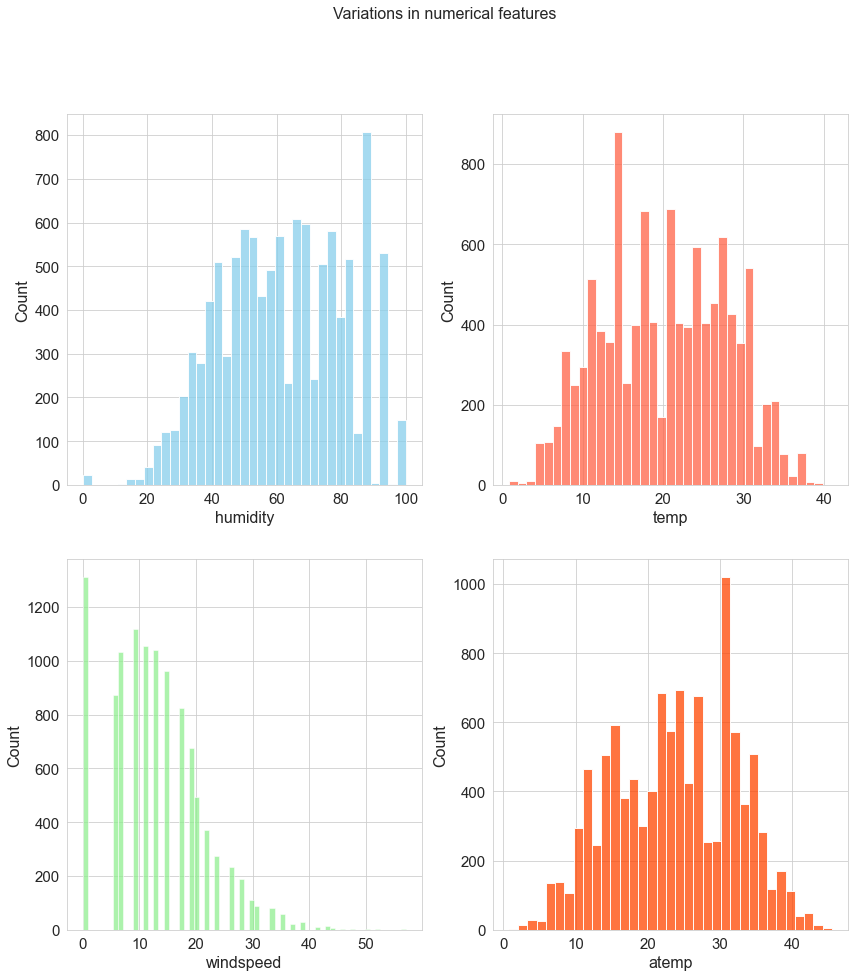

In [10]:
# observing the data distibution of numerical data

fig, ax = plt.subplots(2,2,figsize=(14,15))
plt.suptitle('Variations in numerical features', fontsize=16)

sns.histplot(x ='humidity', data = df_train, ax=ax[0,0], color='skyblue')
sns.histplot(x ='temp', data = df_train, ax=ax[0,1], color='tomato')
sns.histplot(x ='windspeed', data = df_train, ax=ax[1,0], color='lightgreen')
sns.histplot(x ='atemp', data = df_train, ax=ax[1,1], color='orangered')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Clear, Few clouds, Partly cloudy, Partly cloudy'),
  Text(1, 0, 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist'),
  Text(2, 0, 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds'),
  Text(3, 0, 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog')])

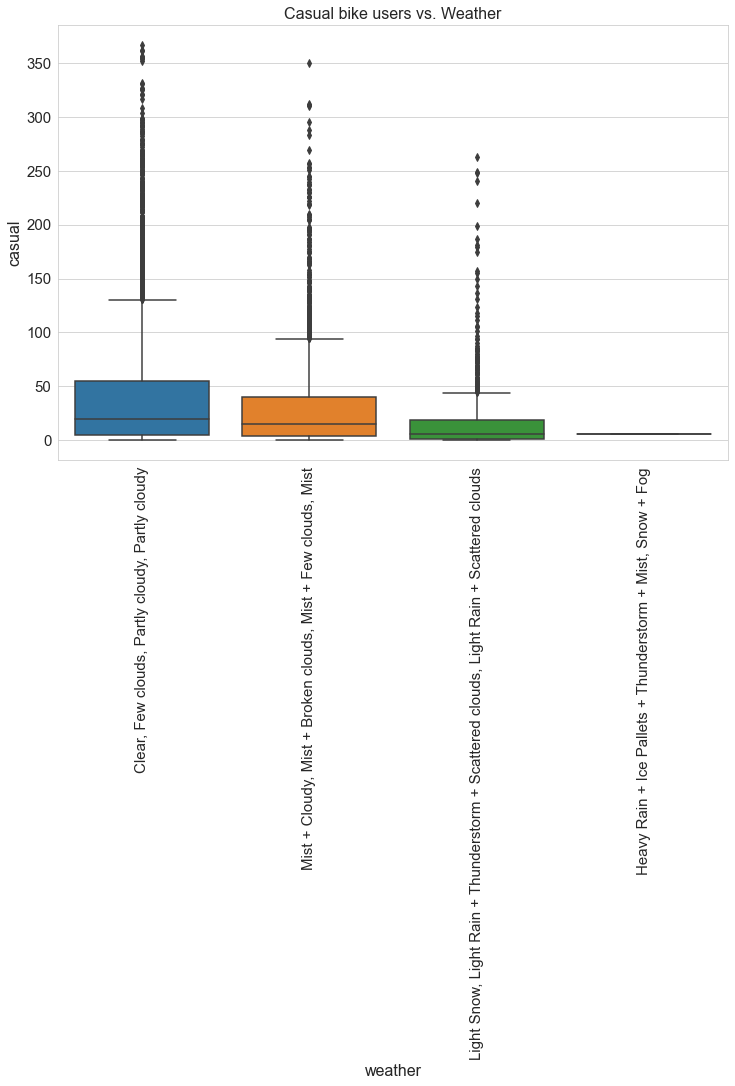

In [11]:
weather_map = {1: 'Clear, Few clouds, Partly cloudy, Partly cloudy',
    2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
    3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
    4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'}


plt.figure(figsize=(12,8))

sns.boxplot(x=df_train['weather'].map(weather_map), y=df_train['casual'])
plt.title('Casual bike users vs. Weather')
plt.xticks(rotation=90)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Clear, Few clouds, Partly cloudy, Partly cloudy'),
  Text(1, 0, 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist'),
  Text(2, 0, 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds'),
  Text(3, 0, 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog')])

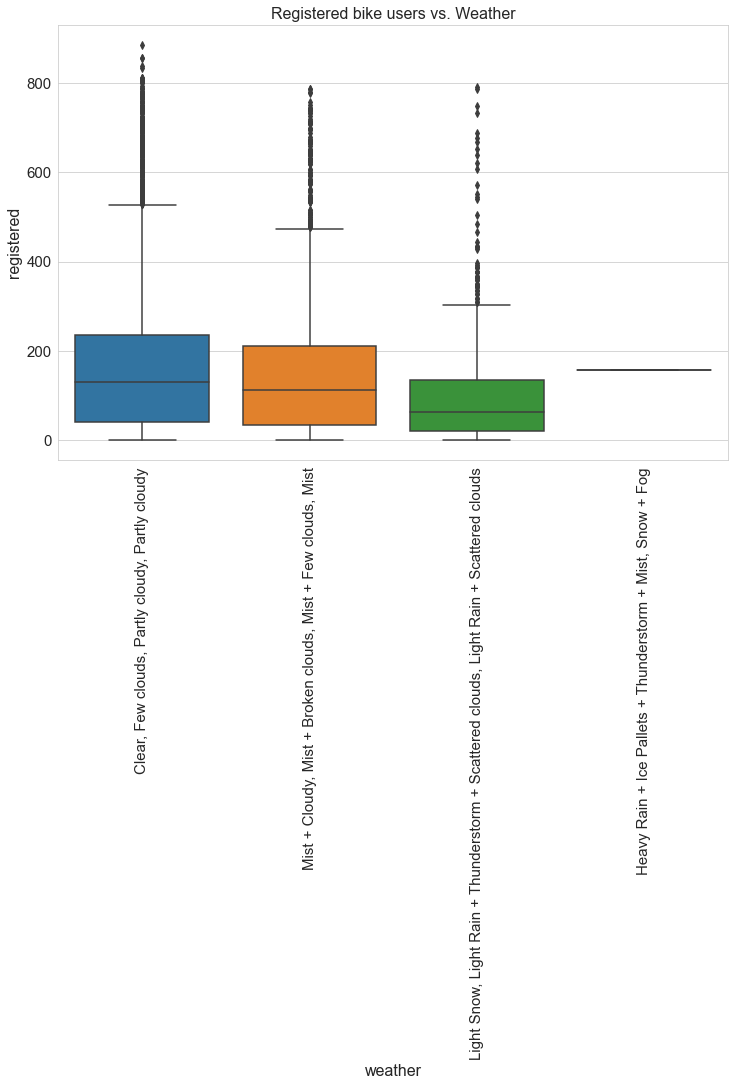

In [12]:
plt.figure(figsize=(12,8))

sns.boxplot(x=df_train['weather'].map(weather_map), y=df_train['registered'])
plt.title('Registered bike users vs. Weather')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Casual bike users vs. Holiday')

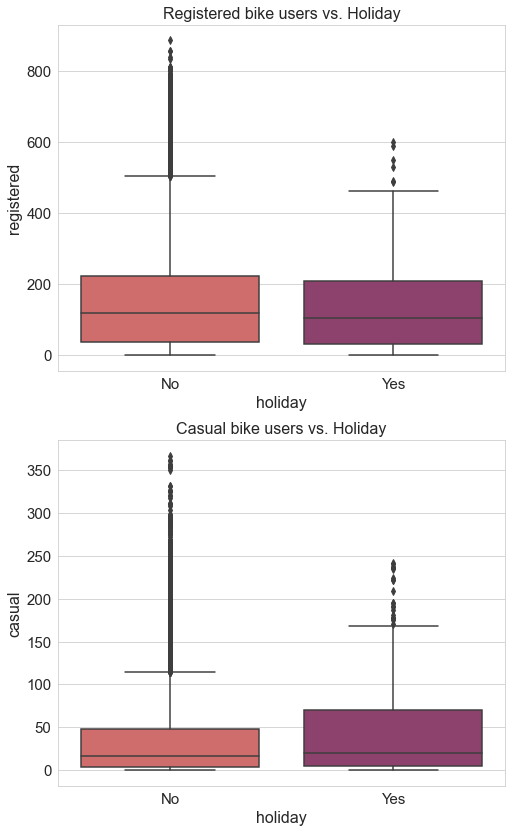

In [13]:
day_map = {1: 'Yes', 0: 'No'}

fig, ax = plt.subplots(2,1,figsize=(8,14))

sns.boxplot(x=df_train['holiday'].map(day_map), y=df_train['registered'], ax=ax[0], palette='flare')
ax[0].set_title('Registered bike users vs. Holiday')

sns.boxplot(x=df_train['holiday'].map(day_map), y=df_train['casual'], ax=ax[1], palette='flare')
plt.title('Casual bike users vs. Holiday')

Text(0.5, 1.0, 'Casual bike users vs. Workingday')

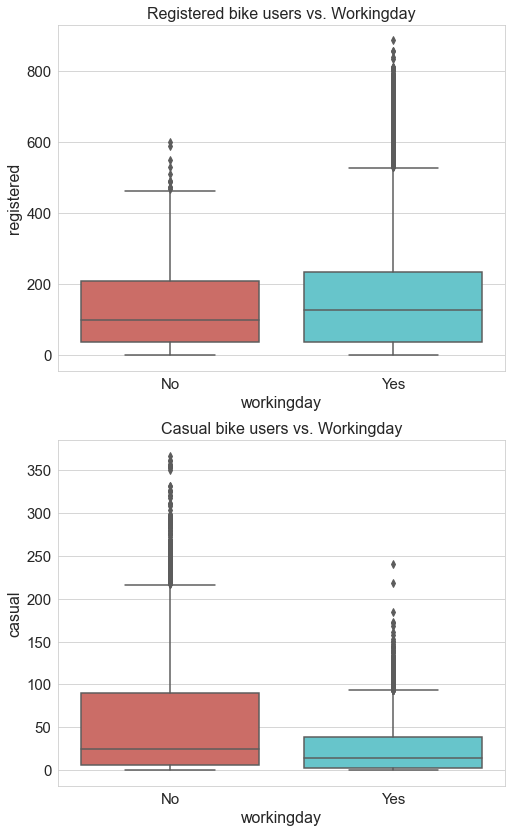

In [14]:
fig, ax = plt.subplots(2,1,figsize=(8,14))

sns.boxplot(x=df_train['workingday'].map(day_map), y=df_train['registered'],ax=ax[0], palette='hls')
ax[0].set_title('Registered bike users vs. Workingday')

sns.boxplot(x=df_train['workingday'].map(day_map), y=df_train['casual'], ax=ax[1], palette='hls')
plt.title('Casual bike users vs. Workingday')

# It seems that casual bike users typically rent bikes on a non-working days, whereas registered bike users typically rent bikes on working days

Text(0.5, 1.0, 'Casual users vs. Season')

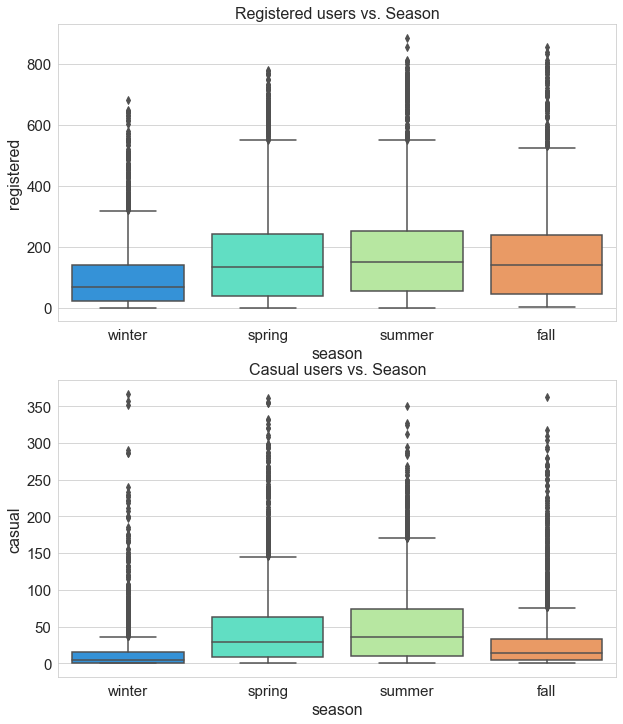

In [15]:
fig, ax = plt.subplots(2,1,figsize=(10,12))

season_map = {1:'winter', 2:'spring', 3:'summer', 4:'fall'}


sns.boxplot(x=df_train['season'].map(season_map), y=df_train['registered'], ax=ax[0], palette='rainbow')
ax[0].set_title('Registered users vs. Season')

sns.boxplot(x=df_train['season'].map(season_map), y=df_train['casual'], ax=ax[1], palette='rainbow')
ax[1].set_title('Casual users vs. Season')

# Visualizing the casual and registered users hourly demand at different seasons

Text(0.5, 1.0, 'Casual users vs. Hour')

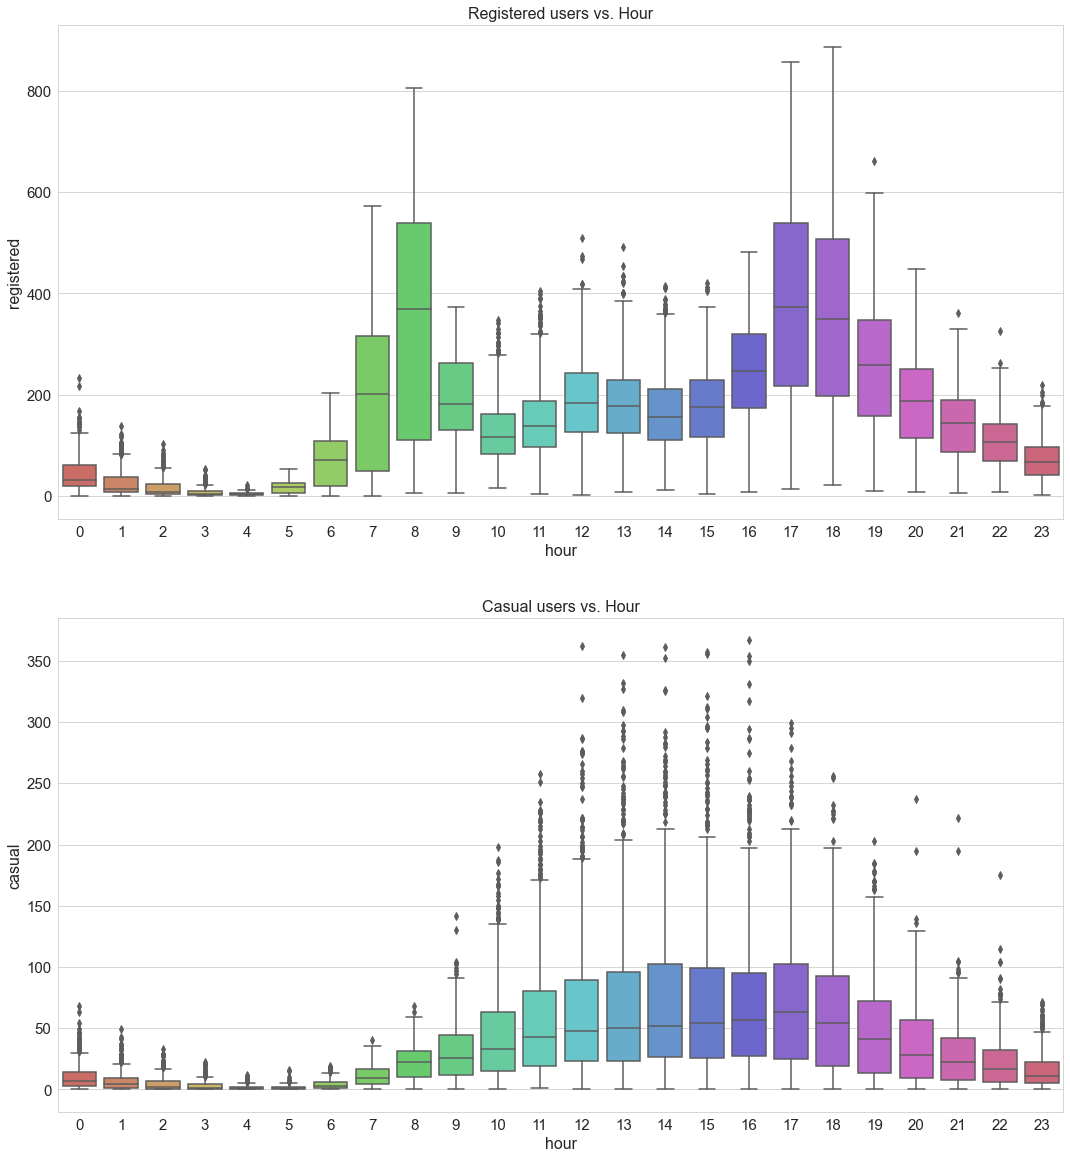

In [16]:
fig, ax = plt.subplots(2,1,figsize=(18,20))

sns.boxplot(x=df_train['hour'], y=df_train['registered'], ax=ax[0], palette='hls')
ax[0].set_title('Registered users vs. Hour')

sns.boxplot(x=df_train['hour'], y=df_train['casual'], ax=ax[1], palette='hls')
ax[1].set_title('Casual users vs. Hour')

# It looks like registered users typically rent bikes relatively more in the morning between 07:00 - 08:00 hrs and in the evening between 17:00 - 18:00 hrs 

# Casual users typically rent bikes between 10:00 - 19:00 hrs and the usage is approximately evenly distributed between 13:00 - 17:00

# Visualizing the casual and registered users hourly demand at different seasons

Text(0.5, 1.0, 'Casual users vs. Hour and Season')

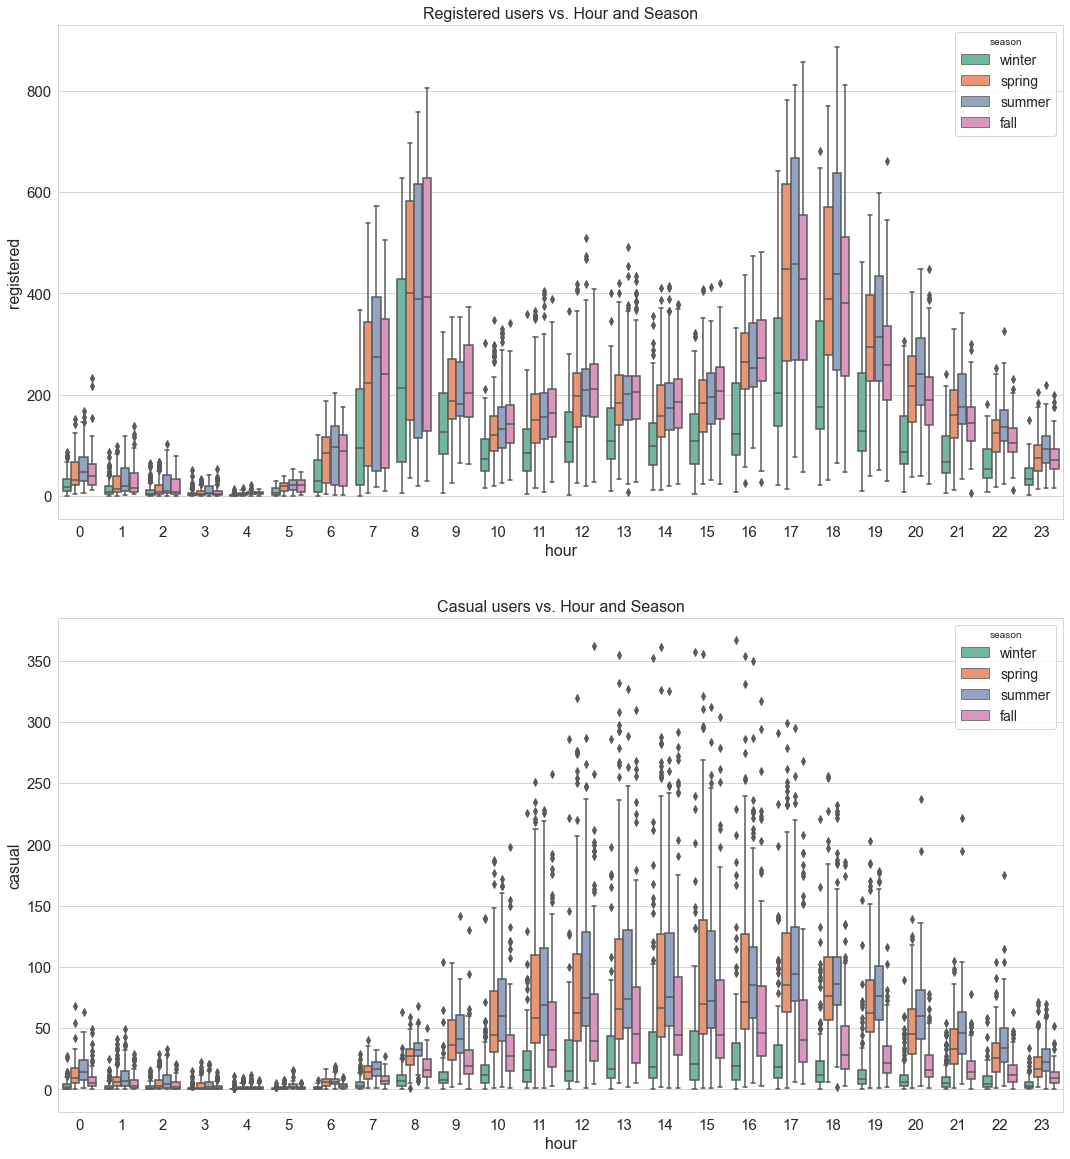

In [17]:
fig, ax = plt.subplots(2,1,figsize=(18,20))

sns.boxplot(x=df_train['hour'], y=df_train['registered'], hue=df_train['season'].map(season_map), ax=ax[0],
           palette='Set2')
ax[0].set_title('Registered users vs. Hour and Season')

sns.boxplot(x=df_train['hour'], y=df_train['casual'], hue=df_train['season'].map(season_map), ax=ax[1],
           palette='Set2')
ax[1].set_title('Casual users vs. Hour and Season')


# Registered users tend to rent bikes more during Spring, Summer and Fall 

# Casual users tend to rent bikes more during Spring and Summer

# Visualizing the casual and registered users demand at different weather

Text(0.5, 1.0, 'Casual users vs. Hour and Weather')

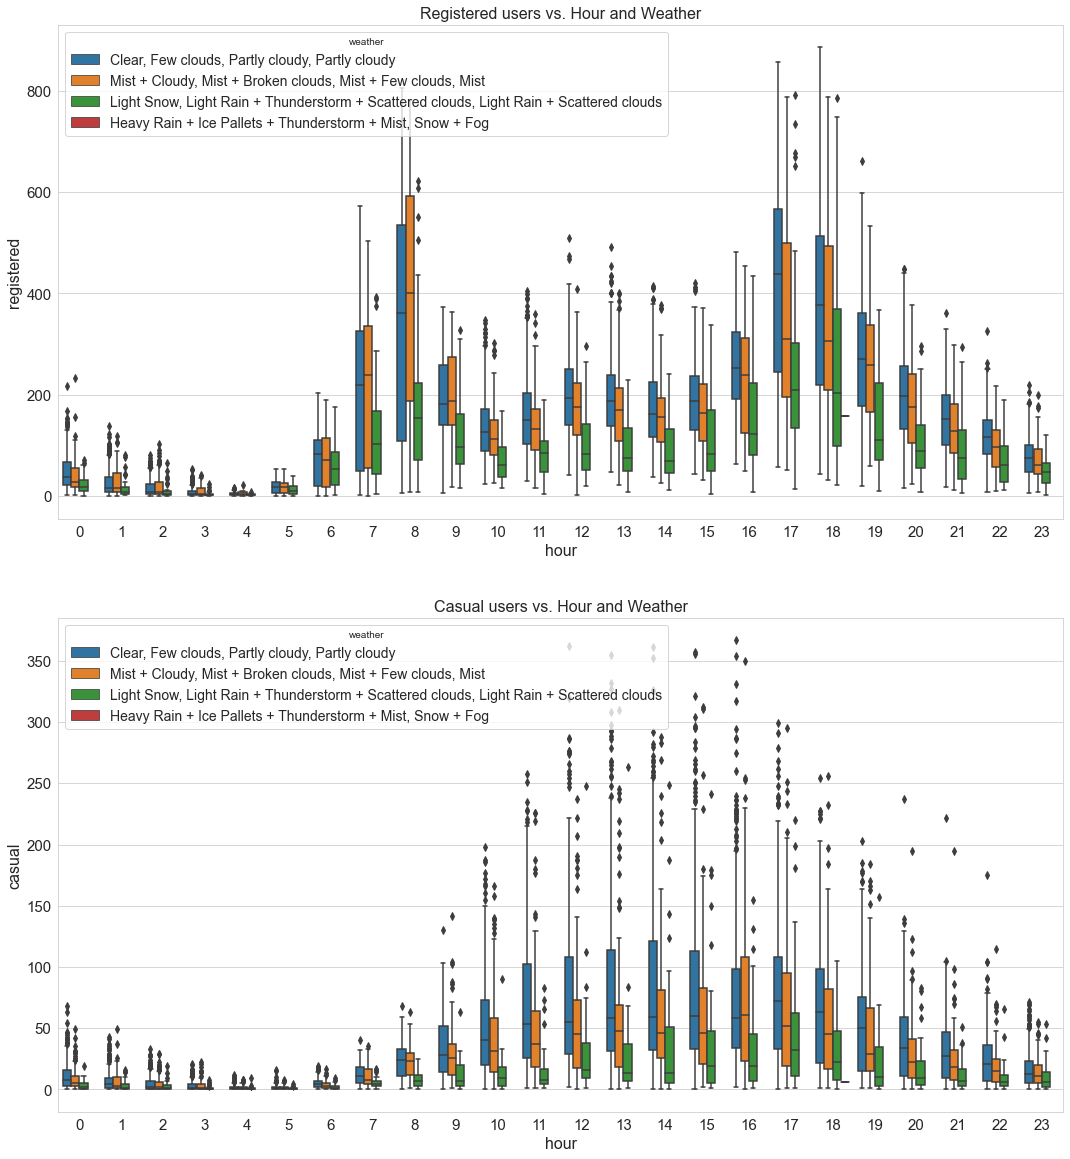

In [18]:
fig, ax = plt.subplots(2,1,figsize=(18,20))

sns.boxplot(x=df_train['hour'], y=df_train['registered'], hue=df_train['weather'].map(weather_map), ax=ax[0])
ax[0].set_title('Registered users vs. Hour and Weather')

sns.boxplot(x=df_train['hour'], y=df_train['casual'], hue=df_train['weather'].map(weather_map), ax=ax[1])
ax[1].set_title('Casual users vs. Hour and Weather')

# Registered users and Casual users tend to rent bikes when the weather is Clear/Few clouds or Misty/Cloudy.

# Neither users rent bikes during heavy rain/thunderstorm, as expected

# Visualizing registered and casual users demand on a day-to-day basis

Text(0.5, 1.0, 'Casual users vs. Day of Week')

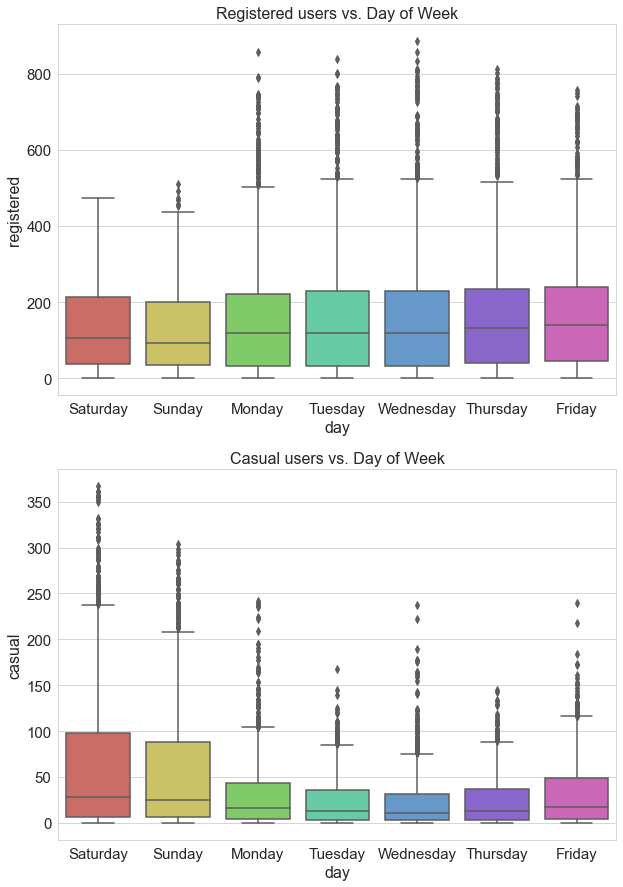

In [19]:
day_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}


fig,ax = plt.subplots(2,1,figsize=(10,15))
sns.boxplot(x=df_train['day'].map(day_map),y='registered',data=df_train, ax=ax[0], palette = 'hls')
ax[0].set_title('Registered users vs. Day of Week')

sns.boxplot(x=df_train['day'].map(day_map),y='casual',data=df_train, ax=ax[1], palette = 'hls')
ax[1].set_title('Casual users vs. Day of Week')


# It looks like casual users tend to rent bikes more on weekends and registered users rent evenly across all days of the week

# Visualizing registered and casual users monthly demand 

Text(0.5, 1.0, 'Casual users vs. Month')

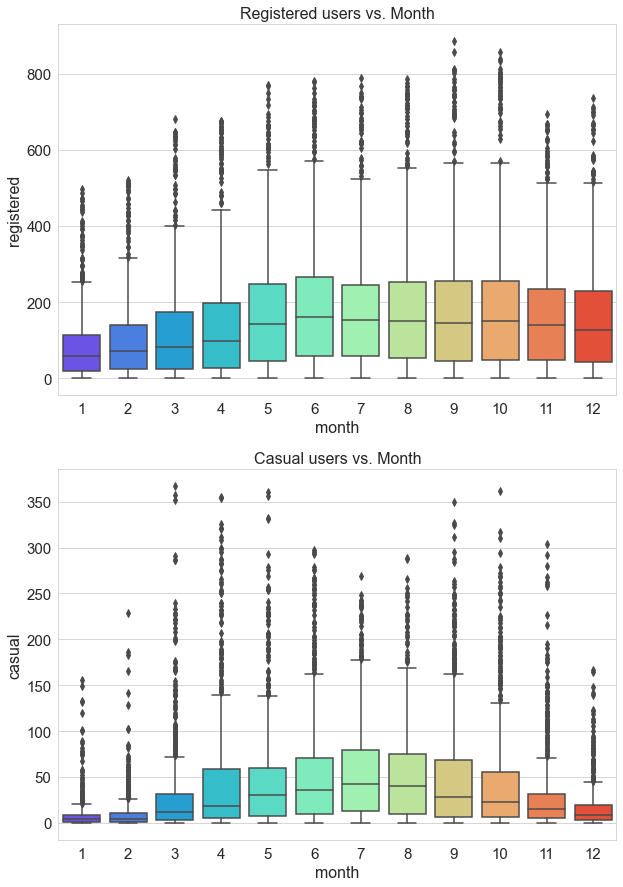

In [20]:

fig,ax = plt.subplots(2,1,figsize=(10,15))
sns.boxplot(x='month',y='registered',data=df_train, ax=ax[0], palette = 'rainbow')
ax[0].set_title('Registered users vs. Month')

sns.boxplot(x='month',y='casual',data=df_train, ax=ax[1], palette = 'rainbow')
ax[1].set_title('Casual users vs. Month')

# Casual users tend to rent bikes more between April - October, whereas registered users tend to rent bikes more between May - December compared to other months

Text(0.5, 1.0, 'Visualizing numerical features')

<Figure size 720x720 with 0 Axes>

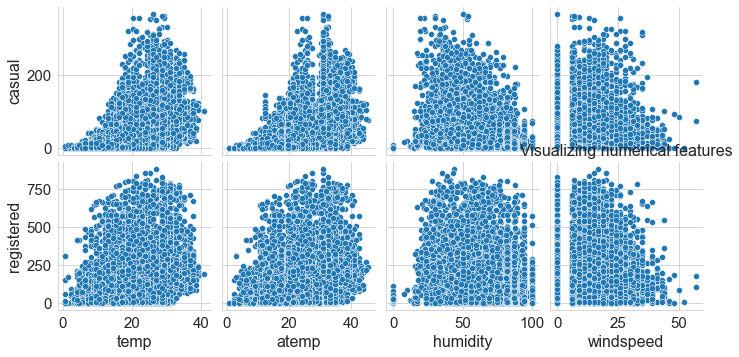

In [21]:
plt.figure(figsize=(10,10))

sns.pairplot(df_train, x_vars=['temp','atemp','humidity','windspeed'], y_vars=['casual','registered'])
plt.title('Visualizing numerical features')

In [22]:
# atemp and temp features are highly correlated, and do not add uniqueness to the features, hence removing 'atemp'

df_train.drop('atemp',axis=1, inplace=True)


# Evaluating the numerical features' importance through correlation

<AxesSubplot:>

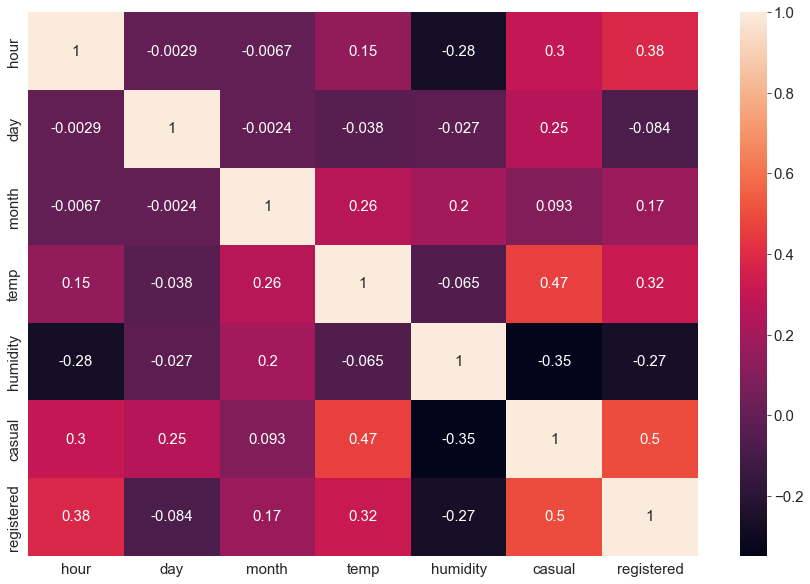

In [23]:
plt.figure(figsize=(15,10))
sns.heatmap(df_train[['hour','day','month','temp','humidity','casual','registered']].corr(), annot=True, 
            annot_kws={'fontsize':15})

In [24]:
# Windspeed feature has low correlation to casual and registered users, so removing it

df_train.drop('windspeed',axis=1,inplace=True)

Numerical features with relatively high correlation are considered for training.

# Evaluating categorical features' importance through ANOVA

Null Hypothesis (Ho): The target variable and input feature are similar and there is no correlation between the groups

If p-value less than 0.05, the null hypothesis is rejected, indicating that there is correlation between the target and input feature

In [25]:
from scipy.stats import f_oneway


def anova_test(df,feature_list,target_var):
    
    for feature in feature_list:
        
        anova_group  = df.groupby(feature)[target_var].apply(list)
        f_dist = f_oneway(*anova_group)
        
        print("p-value for feature '{}' with target variable '{}': {}".format(feature,target_var,f_dist[1]))

print("For 'Registered' target variable: \n")
anova_test(df_train,['season', 'holiday', 'workingday', 'weather'],'registered')
print("\n")
print("For 'Casual' target variable: \n")
anova_test(df_train,['season', 'holiday', 'workingday', 'weather'],'casual')


For 'Registered' target variable: 

p-value for feature 'season' with target variable 'registered': 1.7034253905273869e-106
p-value for feature 'holiday' with target variable 'registered': 0.028669581571654053
p-value for feature 'workingday' with target variable 'registered': 7.9596854951837e-36
p-value for feature 'weather' with target variable 'registered': 1.9679444359040236e-31


For 'Casual' target variable: 

p-value for feature 'season' with target variable 'casual': 8.986023635623083e-214
p-value for feature 'holiday' with target variable 'casual': 4.87213996153447e-06
p-value for feature 'workingday' with target variable 'casual': 2.2499934021302947e-256
p-value for feature 'weather' with target variable 'casual': 3.117246631062602e-44


Since p-value is <0.05 for all the above features, they are considered for training the model

# Checking and transforming categorical values to numbers, if any

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10885 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10885 non-null  int64  
 1   holiday     10885 non-null  int64  
 2   workingday  10885 non-null  int64  
 3   weather     10885 non-null  int64  
 4   temp        10885 non-null  float64
 5   humidity    10885 non-null  int64  
 6   casual      10885 non-null  int64  
 7   registered  10885 non-null  int64  
 8   count       10885 non-null  int64  
 9   hour        10885 non-null  int64  
 10  day         10885 non-null  int64  
 11  month       10885 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 1.3 MB


# Normalizing data and training model

In [27]:
#organizing independent and dependent variables and selecting important features from the above analysis

X_df = df_train[['hour','day','month','season', 'holiday', 'workingday', 
                'weather', 'temp', 'humidity']]

Y_cas_df = df_train['casual']
Y_reg_df = df_train['registered']

# Training the models

In [28]:
def train_models(X_df,Y_cas_df,Y_reg_df):
    
    # Normalizing data
    
    #norm = MinMaxScaler()
    #X_df = norm.fit_transform(X_df)

    # Splitting data for training and testing
    # Casual users and registered users will be trained, tested separetely and will be added to obtain total count
    
    x_reg_train,x_reg_test,y_reg_train,y_reg_test = train_test_split(X_df,Y_reg_df,test_size=0.2)
    x_cas_train,x_cas_test,y_cas_train,y_cas_test = train_test_split(X_df,Y_cas_df,test_size=0.2)
    
    models_list = [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor(), XGBRegressor()]
    
    res_dict={'Model':['Linear Regression','Random Forest Regressor', 'Decision Tree Regressor', 
                      'XGBoost Regressor'],
              'RMSLE':[]}
    
    for mod_val in models_list:
        
        model1 = mod_val
        model2 = mod_val
        
        model1.fit(x_reg_train,y_reg_train)
        model2.fit(x_cas_train,y_cas_train)
        
        model1_pred = model1.predict(x_reg_test)
        model2_pred = model2.predict(x_cas_test)
        
        total_count_pred = model1_pred + model2_pred
        
        total_count_true = pd.Series.to_numpy(y_reg_test) + pd.Series.to_numpy(y_cas_test)
          
        
        # some of the models are predicting negative values, which doesn't make sense. So, setting them to 0.
        for val in range(len(total_count_pred)):
            if total_count_pred[val] < 0:
                total_count_pred[val]=0
        
        rmsle = np.sqrt(mean_squared_log_error(total_count_true, total_count_pred))
        
        res_dict['RMSLE'].append(np.round(rmsle,5))
        
        print("Model: {} \n Root Mean Square Log Error: {}\n".format(str(mod_val),np.round(rmsle,5)))
    
    return(res_dict)
        
res_dict = train_models(X_df,Y_cas_df,Y_reg_df)

Model: LinearRegression() 
 Root Mean Square Log Error: 1.56549

Model: RandomForestRegressor() 
 Root Mean Square Log Error: 1.28171

Model: DecisionTreeRegressor() 
 Root Mean Square Log Error: 1.36532



/opt/homebrew/Caskroom/miniforge/base/envs/tf_gpu/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 
 Root Mean Square Log Error: 1.34318



Text(0.5, 1.0, 'Model vs. RMSLE')

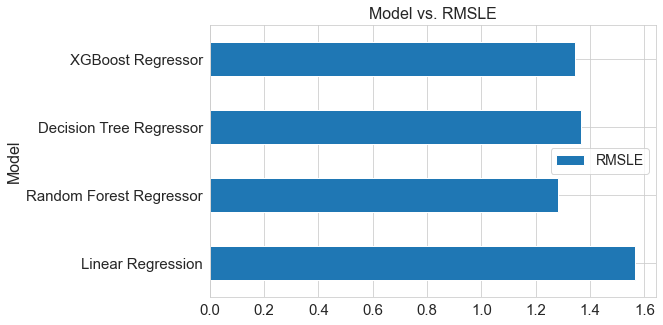

In [29]:
res_df = pd.DataFrame(res_dict)

res_df.plot(x='Model',y='RMSLE',kind='barh', figsize=(8,5))
plt.title('Model vs. RMSLE')


# Since Random Forest Regressor model has the least RMS log error, the model will be tuned and trained on the entire training dataset 

In [30]:
# identifying the best parameters casual and registered users separately

param_dict = {'n_estimators':[100],'n_jobs':[-1],'max_features':['auto','sqrt','log2']}

grid_reg = GridSearchCV(estimator=RandomForestRegressor(),param_grid = param_dict)
grid_reg.fit(X_df,Y_reg_df)

grid_cas = GridSearchCV(estimator=RandomForestRegressor(),param_grid = param_dict)
grid_cas.fit(X_df,Y_cas_df)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100], 'n_jobs': [-1]})

In [31]:
# best params for predicting registered users 
grid_reg.best_params_

{'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1}

In [32]:
# best params for predicting casual users 
grid_cas.best_params_

{'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1}

Root Mean Square Log Error: 0.19577


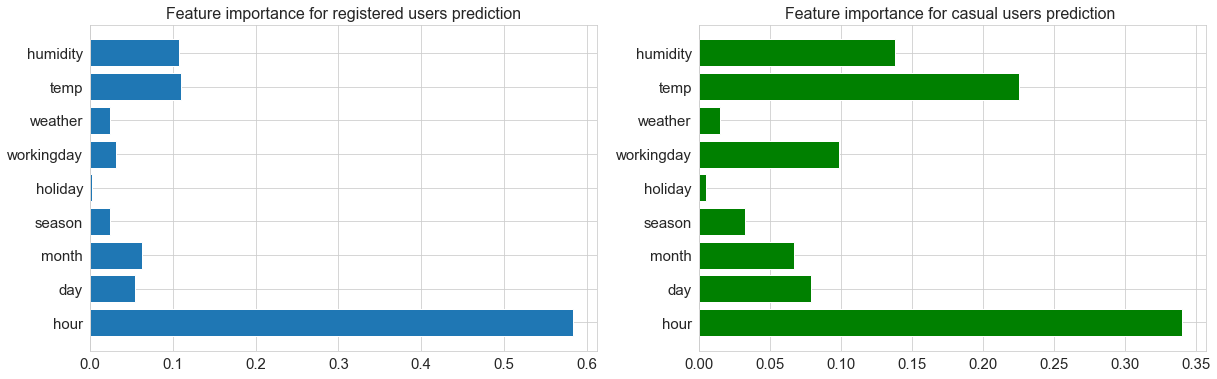

In [33]:
# Training RandomForestRegressor model on the entire train dataset separately to visualize feature importance

RFR_registered = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1)
RFR_registered.fit(X_df,Y_reg_df)

RFR_casual = RandomForestRegressor(n_estimators=100, max_features='log2', n_jobs=-1)
RFR_casual.fit(X_df,Y_cas_df)


feat_label = ['hour','day','month','season', 'holiday', 'workingday', 
                'weather', 'temp', 'humidity']

fig,ax = plt.subplots(1,2,figsize=(20,6))
ax[0].barh(feat_label, RFR_registered.feature_importances_)
ax[0].set_title('Feature importance for registered users prediction')

ax[1].barh(feat_label, RFR_casual.feature_importances_, color='green')
ax[1].set_title('Feature importance for casual users prediction ')


RFR_registered_pred = RFR_registered.predict(X_df)
RFR_casual_pred = RFR_casual.predict(X_df)

count_pred = RFR_registered_pred + RFR_casual_pred

rmsle = np.sqrt(mean_squared_log_error(df_train['count'],count_pred))

print("Root Mean Square Log Error:", np.round(rmsle,5))

# Pre-processing test data and predicting total bike demand

In [34]:
# Test data pre-processing

def test_data_preprocess(df_test):
    
    df_test['datetime'] = df_test['datetime'].apply(lambda time:pd.to_datetime(time))

    df_test['hour'] = df_test['datetime'].apply(lambda hr: hr.hour)
    df_test['day'] = df_test['datetime'].apply(lambda dy:dy.dayofweek)
    df_test['month'] = df_test['datetime'].apply(lambda mnth: mnth.month)

    df_test.drop('datetime',axis=1, inplace=True)
    
    df_test.drop('atemp',axis=1, inplace=True)
    df_test.drop('windspeed',axis=1, inplace=True)
    
    # returning the test data features in the same order the model was trained on train data
    
    return(df_test[['hour','day','month','season', 'holiday', 'workingday', 
                'weather', 'temp', 'humidity']])

df_test = test_data_preprocess(df_test)

In [35]:
# Predicting total bike demand

testdata_reg_pred = RFR_registered.predict(df_test)
testdata_cas_pred = RFR_casual.predict(df_test)

testdata_count = np.round(testdata_reg_pred + testdata_cas_pred)

# converting predicted values to integer format

testdata_count = testdata_count.astype(int)

In [36]:
# storing the results in a dataframe

testdata_df = pd.DataFrame(testdata_count,columns=['Bike count'])
testdata_df.head(10)

,Bike count
0,20
1,13
2,12
3,11
4,10
5,15
6,61
7,191
8,320
9,172
